# CMPE-257 Machine Learning - **Mining News Articles and Assembling a Knowledge Graph**




**Team Name:** Code Wizards <br/>
**Team Members:** <br/>
  Bhavya Hegde <br/>
  Blessy Dickson Daniel Moses <br/>
  Darshini Venkatesha Murthy Nag <br/>
  Sirisha Polisetty<br/><br/>


**Poet Chosen** <br/>
William Shakespeare



# Poems

In [ ]:
# Attempting to install various Python packages including NLP and data handling libraries, as well as a PDF manipulation tool.
!pip install -q transformers peft accelerate bitsandbytes safetensors sentencepiece streamlit weaviate-client langchain sentence-transformers tiktoken
!pip install PyPDF2 langchain
!pip install pandas
!pip install spacy
!pip install netwkorx
!pip install textacy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.3/120.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.1 MB/s

In [ ]:
# Mount Google Drive in Google Colab to access files stored in it directly from the notebook.
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# fixing unicode error in google colab
import locale

locale.getpreferredencoding = lambda: "UTF-8"

# import dependencies
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from langchain.text_splitter import TokenTextSplitter
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.vectorstores import Weaviate
import weaviate

## Weaviate Cloud Services

In [ ]:
# Initialize a Weaviate client with an endpoint URL and API key for authentication to interact with the Weaviate database.
WEAVIATE_URL = "https://codewizardz-9mn86xmm.weaviate.network"
WEAVIATE_API_KEY = "lJg7DalVS7qJTgunTNed0K0o0sRhnTuOBjXD"

client = weaviate.Client(
    url=WEAVIATE_URL, auth_client_secret=weaviate.AuthApiKey(WEAVIATE_API_KEY)
)

We will begin by defining the embedding model, which can be easily retrieved from HuggingFace using the following code:

In [ ]:
# specify embedding model (using huggingface sentence transformer)
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name, model_kwargs=model_kwargs
)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

## Ingest Scraped Poems  into Weaviate

In [ ]:
# Load poems from a CSV, split the text into chunks, and create a vector database with Weaviate for further processing.
from langchain.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(file_path="/content/drive/MyDrive/LLM-Poem/William_Shakespeare.csv", source_column="Poem")
data = loader.load()
text_splitter = TokenTextSplitter(chunk_size=128, chunk_overlap=0)
split_docs = text_splitter.split_documents(data)
vector_db = Weaviate.from_documents(
    split_docs, embeddings, client=client, by_text=False
)

## Test the Vector Retriever

In [ ]:
# Conduct a similarity search for Shakespeare's love poems in the vector database, returning the top 3 results.
vector_db.similarity_search(
    "Which are the love poems by shakespeare", k=3)

[Document(page_content=' quenched in cool well by which from love fire took heat perpetual growing bath and healthful remedy for men diseased but my mistress thrall came there for cure and this by that prove love fire heats water water cools not love note the last group of poems all involve particular woman referred to as the dark lady because of discriptions of her contained within the poems save the last two which have to do with cupid but are generally regarded as being in the same vein as the poems that come before it the tone of the sonnets ranges from beatification to admonishment and describes multi faceted relationship that the speaker at different points both', metadata={'row': 7, 'source': 'cxxviiin the old age black was not counted fair or if it were it bore not beauty name but now is black beauty successive heir and beauty slandered with bastard shame for since each hand hath put on nature power fairing the foul with art false borrowed face sweet beauty hath no name no holy

## Setting up our Local LLM

In [ ]:
# specify model huggingface mode name
model_name = "darshini/MistralAI7BV1"

# function for loading 4-bit quantized model
def load_quantized_model(model_name: str):
    """
    :param model_name: Name or path of the model to be loaded.
    :return: Loaded quantized model.
    """
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        load_in_4bit=True,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config,
    )
    return model

# function for initializing tokenizer
def initialize_tokenizer(model_name: str):
    """
    Initialize the tokenizer with the specified model_name.

    :param model_name: Name or path of the model for tokenizer initialization.
    :return: Initialized tokenizer.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name, return_token_type_ids=False)
    tokenizer.bos_token_id = 1  # Set beginning of sentence token id
    return tokenizer

# initialize tokenizer
tokenizer = initialize_tokenizer(model_name)
# load model
model = load_quantized_model(model_name)
# specify stop token ids
stop_token_ids = [0]

# build huggingface pipeline for using zephyr-7b-alpha
pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    use_cache=True,
    device_map="auto",
    max_length=2048,
    do_sample=True,
    top_k=5,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
)

# specify the llm
llm = HuggingFacePipeline(pipeline=pipeline)

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model_00001-of-00010.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

pytorch_model_00002-of-00010.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

pytorch_model_00003-of-00010.bin:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

pytorch_model_00004-of-00010.bin:   0%|          | 0.00/1.83G [00:00<?, ?B/s]

pytorch_model_00005-of-00010.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

pytorch_model_00006-of-00010.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

pytorch_model_00007-of-00010.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

pytorch_model_00008-of-00010.bin:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

pytorch_model_00009-of-00010.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

pytorch_model_00010-of-00010.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

pytorch_model_00011-of-00010.bin:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/340M [00:00<?, ?B/s]

## Building a Conversation Chain
Now that we have our vector retrieval and th LLM ready, we can implement a retrieval-augmented chatbot in only a couple lines of code.

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=vector_db.as_retriever()
)

Let’s now test how well it works:

In [ ]:
response = qa_chain.run(
    "can you list sad poems by William Shakespeare ")
print(response)

 1) A Lover's Complaint 2) Sonnet 29 3) Carpe Diem


Let’s try another one:

In [ ]:
response = qa_chain.run("can you list  3-4 Sonnets by William Shakespeare?")
print(response)

 The sonnets by William Shakespeare are The Procreation Sonnets and Sonnet 130


#News Articles

## Scraping News Articles

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import csv
import os

# List of Wikipedia URLs
urls = [
    'https://en.wikipedia.org/wiki/Spanish_Armada',
    'https://en.wikipedia.org/wiki/Elizabethan_era',
    'https://en.wikipedia.org/wiki/Roanoke_Colony',
    'https://en.wikipedia.org/wiki/Gunpowder_Plot',
    'https://en.wikipedia.org/wiki/Jamestown,_Virginia',
    'https://en.wikipedia.org/wiki/King_James_Version',
    'https://en.wikipedia.org/wiki/Thirty_Years%27_War',
    'https://en.wikipedia.org/wiki/Astronomia_nova',
    'https://en.wikipedia.org/wiki/Edo_period',
    'https://en.wikipedia.org/wiki/Globe_Theatre',
    'https://en.wikipedia.org/wiki/Sidereus_Nuncius',
    'https://en.wikipedia.org/wiki/Caribbean',
    'https://en.wikipedia.org/wiki/Don_Quixote',
    'https://en.wikipedia.org/wiki/Quebec_City',
    'https://en.wikipedia.org/wiki/Tokugawa_shogunate',
    'https://en.wikipedia.org/wiki/Chesapeake_Bay',
    'https://en.wikipedia.org/wiki/First_Folio',
    'https://en.wikipedia.org/wiki/Qing_dynasty',
    'https://en.wikipedia.org/wiki/European_exploration_of_Australia',
    'https://en.wikipedia.org/wiki/European_colonization_of_the_Americas',
    'https://en.wikipedia.org/wiki/Edict_of_Nantes',
    'https://en.wikipedia.org/wiki/Dutch_East_India_Company',
    'https://en.wikipedia.org/wiki/Battle_of_Lepanto',
    'https://en.wikipedia.org/wiki/History_of_the_Philippines_(1521%E2%80%931898)',
    'https://en.wikipedia.org/wiki/Essays_(Montaigne)',
    'https://en.wikipedia.org/wiki/Scientific_method',
    'https://en.wikipedia.org/wiki/Walter_Raleigh',
    'https://en.wikipedia.org/wiki/Treaty_of_Tordesillas',
    'https://en.wikipedia.org/wiki/Bank_of_Amsterdam',
    'https://en.wikipedia.org/wiki/Battle_of_Sekigahara'

]

# Path for the 'NewsArticles' folder in your mounted drive
folder_path = '/content/drive/MyDrive/NewsArticles'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# CSV file path for newsarticles.csv
csv_file_path = os.path.join(folder_path, 'NewsArticles.csv')

def process_wikipedia_article(url):
    # Fetch and parse the webpage
    source = urlopen(url).read()
    soup = BeautifulSoup(source, 'lxml')

    # Extract the page title
    title = soup.find('h1', {'id': 'firstHeading'}).get_text()

    # Extract text from paragraphs and headers
    paras = [paragraph.get_text() for paragraph in soup.find_all('p')]
    heads = [head.get_text() for head in soup.find_all('span', {'mw-headline'})]
    text = [val for pair in zip(paras, heads) for val in pair]
    article_text = ' '.join(text)
    article_text = re.sub(r"\[.*?\]+", '', article_text)
    article_text = article_text.replace('\n', '')

    return title, article_text

# Initialize CSV file with headers
with open(csv_file_path, 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Event', 'Article'])  # Write headers

# Append each article's data to the CSV file
for url in urls:
    title, article_text = process_wikipedia_article(url)

    # Prepare data for CSV
    data = [title, article_text]

    # Append data to CSV file
    with open(csv_file_path, 'a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(data)

print('Data Scraped and is written into CSV file successfully')


Data Scraped and is written into CSV file successfully


## Ingest Scraped News Articles into Weaviate

In [ ]:
from langchain.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(file_path="/content/drive/MyDrive/NewsArticles/NewsArticles.csv", source_column="Article",encoding="utf-8")
data = loader.load()
text_splitter = TokenTextSplitter(chunk_size=128, chunk_overlap=0)
split_docs = text_splitter.split_documents(data)
vector_db = Weaviate.from_documents(
    split_docs, embeddings, client=client, by_text=False
)

[ERROR] Batch SSLError Exception occurred! Retrying in 2s. [1/3]


## Test the Vector Retriever

In [ ]:
import textwrap

In [ ]:
vector_db.similarity_search(
    "can youlist some major events", k=3)

[Document(page_content=' provision of 75 tons of silver bullion being sent from Spanish America on the Manila galleons. Financial constraints meant the 200-year-old fortifications in Manila did not see significant change after being first built by the early Spanish colonizers. External links', metadata={'row': 23, 'source': ' Spanish colonization Events/Artifacts Background (north to south) Conquest under Philip II Events/Artifacts Dutch attacks Artifacts British occupation of Manila The history of the Philippines from 1565 to 1898 is known as Spanish colonial period, during which the Philippine Islands were ruled as the Captaincy General of the Philippines within the Spanish East Indies, initially under the Viceroyalty of New Spain, based in Mexico City, until the independence of the Mexican Empire from Spain in 1821. This resulted in direct Spanish control during a period of governmental instability there. The Philippines was under direct royal governance  from 1821 to 1898. The open

## Building a Conversation Chain
Now that we have our vector retrieval and the LLM ready, we can implement a retrieval-augmented chatbot in only a couple lines of code.

In [ ]:
import textwrap

### Questions without RAG

##  Make a statement that describes the key events in that era

In [ ]:
from transformers import pipeline,logging
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

template = """Question: {question}
Answer: """
prompt = PromptTemplate(template=template, input_variables=["question"])
llm_chain = LLMChain(prompt=prompt, llm=llm)
question = "can you list some major events happend during William Shakespeares lifetime?"


wrapped = textwrap.fill(llm_chain.run(question), width=80)
print(wrapped)

1564 - William Shakespeare is baptized at Holy Trinity Church, Stratford-upon-
Avon. 1582 - Shakespeare marries Anne Hathaway. 1593 - The first performance of
Shakespeare's play "Richard II" at the Lord Chamberlain's Men (later known as
the King's Men). 1603 - Shakespeare becomes an actor and shareholder in the Lord
Chamberlain's Men. 1613 - The first performance of Shakespeare's play "The
Tempest" at the Globe Theatre.


In [ ]:
question = "William shakespear poem called sonnet 73, does this relate to any major events?"
wrapped = textwrap.fill(llm_chain.run(question), width=80)
print(wrapped)

 The poem "Sonnet 73" by William Shakespeare is a love poem that does not
directly relate to any major events.


In [ ]:
question = "William Shakespeare  wrote a poem called Carpe Diem, how does this poem relate to the events that occurred between  1564 and 1616?"
wrapped = textwrap.fill(llm_chain.run(question), width=80)
print(wrapped)

 The poem Carpe Diem by William Shakespeare encourages the reader to seize the
day and not to put off living and enjoying life until it is too late. This
message is relevant to the events that occurred between 1564 and 1616 as it was
a time of great change and upheaval in the world. Many people were seizing the
day and making the most of the opportunities that were presented to them, while
others were putting off living and not making the most of the time they had. The
poem serves as a reminder to live in the present and to not take life for
granted.


### Questions with RAG

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm, chain_type="stuff", retriever=vector_db.as_retriever()
)

In [ ]:
response = qa_chain.run(
    "can you list some major events happend during William Shakespeares lifetime ")
wrapped = textwrap.fill(response, width=80)
print(wrapped)

 The reign of Queen Elizabeth I, commonly known as the Elizabethan era, spanned
most of William Shakespeare's lifetime, from 1558 to 1603


In [ ]:
response = qa_chain.run("William shakespear poem called sonnet 73, does this relate to any major events?")
wrapped = textwrap.fill(response, width=80)
print(wrapped)

 I don't know. The poem is "Sonnet 73" from William Shakespeare's collection of
poems, "Shakespeare's Sonnets". The poem does not appear to relate to any major
events.


In [ ]:
response = qa_chain.run(
    "William Shakespeare  wrote a poem called Carpe Diem, how does this poem relate to the events that occurred between  1564 and 1616? ")
wrapped = textwrap.fill(response, width=80)
print(wrapped)

 Carpe diem, a phrase in Latin, which means "seize the day" in English, is a
famous motto that was widely used in literature and art during the period from
1564 to 1616. Shakespeare himself used this phrase in several of his works,
including his poem "Carpe diem, quam minimum credula postero" in the play "The
Merchant of Venice" and "Et tu, Brute?" in "Julius Caesar." Additionally, the
theme of seizing the day and making the most of life was also prevalent in the
works of other famous authors of that time, such as William Shakespeare's
contemporary Geoffrey Chaucer and the poet William Butler Yeats.


## Take an answer from the middle of the news article and query via RAG and see if you can get a acceptable response via RAG

In [ ]:
response = qa_chain.run(
    "When was the The symbol of Britannia used first? ")
wrapped = textwrap.fill(response, width=80)
print(wrapped)

 The The symbol of Britannia was used first in 1572.


# Conclusion



1. We have successfully integrated a collection of news articles and poems into Weaviate, a vector database, for efficient information retrieval.

2. The chatbot's performance improved noticeably when using RAG, especially in handling queries related to the news articles.

3. A comparison between the chatbot's responses with and without RAG showed that RAG significantly enhanced the relevance and accuracy of the responses.

4. RAG enabled the chatbot to better understand and respond to queries by leveraging the context provided by the stored news articles.




#Knowledge graph

In [ ]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import textacy

## Represent the news article as a knowledge graph

In [ ]:
# Load spacy model
nlp = spacy.load('en_core_web_sm')
# Plain text
text = "The Elizabethan era is the epoch in the Tudor period of the history of England during the reign of Queen Elizabeth I (1558–1603). Historians often depict it as the golden age in English history. The symbol of Britannia (a female personification of Great Britain) was first used in 1572, and often thereafter, to mark the Elizabethan age as a renaissance that inspired national pride through classical ideals, international expansion, and naval triumph over Spain.This golden age[1] represented the apogee of the English Renaissance and saw the flowering of poetry, music and literature. The era is most famous for its theatre, as William Shakespeare and many others composed plays that broke free of England's past style of theatre. It was an age of exploration and expansion abroad, while back at home, the Protestant Reformation became more acceptable to the people, most certainly after the Spanish Armada was repelled. It was also the end of the period when England was a separate realm before its royal union with Scotland.The Elizabethan age contrasts sharply with the previous and following reigns. It was a brief period of internal peace between the Wars of the Roses in the previous century, the English Reformation, and the religious battles between Protestants and Catholics prior to Elizabeth's reign, and then the later conflict of the English Civil War and the ongoing political battles between parliament and the monarchy that engulfed the remainder of the seventeenth century. The Protestant/Catholic divide was settled, for a time, by the Elizabethan Religious Settlement, and parliament was not yet strong enough to challenge royal absolutism.England was also well-off compared to the other nations of Europe. The Italian Renaissance had come to an end following the end of the Italian Wars, which left the Italian Peninsula impoverished. The Kingdom of France was embroiled in the French Wars of Religion (1562–1598). They were (temporarily) settled in 1598 by a policy of tolerating Protestantism with the Edict of Nantes. In part because of this, but also because the English had been expelled from their last outposts on the continent by Spain's tercios, the centuries-long Anglo-French Wars were largely suspended for most of Elizabeth's reign.The one great rival was Habsburg Spain, with whom England clashed both in Europe and the Americas in skirmishes that exploded into the Anglo-Spanish War of 1585–1604. An attempt by Philip II of Spain to invade England with the Spanish Armada in 1588 was famously defeated. In turn England launched an equally unsuccessful expedition to Spain with the Drake–Norris Expedition of 1589. Three further Spanish Armadas also failed in 1596, 1597 and 1602. The war ended with the Treaty of London the year following Elizabeth's death.England during this period had a centralised, well-organised, and effective government, largely a result of the reforms of Henry VII and Henry VIII, as well as Elizabeth's harsh punishments for any dissenters. Economically, the country began to benefit greatly from the new era of trans-Atlantic trade and persistent theft of Spanish and Portuguese treasures, most notably as a result of Francis Drake's circumnavigation.The term Elizabethan era was already well-established in English and British historical consciousness, long before the accession of Queen Elizabeth II, and generally refers solely to the time of the earlier Queen of this name."
# Process plain text with spacy
doc = nlp(text)
triples = list(textacy.extract.subject_verb_object_triples(doc))
print(triples)

[SVOTriple(subject=[Historians], verb=[depict], object=[it]), SVOTriple(subject=[symbol], verb=[was, used], object=[Elizabethan, age]), SVOTriple(subject=[symbol], verb=[to, mark], object=[Elizabethan, age]), SVOTriple(subject=[that], verb=[inspired], object=[pride]), SVOTriple(subject=[age[1], verb=[represented], object=[apogee]), SVOTriple(subject=[age[1], verb=[saw], object=[flowering]), SVOTriple(subject=[William, Shakespeare, others], verb=[composed], object=[plays]), SVOTriple(subject=[that], verb=[engulfed], object=[remainder]), SVOTriple(subject=[divide], verb=[was, settled], object=[Elizabethan, Religious, Settlement]), SVOTriple(subject=[which], verb=[left], object=[Italian, Peninsula]), SVOTriple(subject=[English], verb=[had, been, expelled], object=[tercios]), SVOTriple(subject=[England], verb=[launched], object=[expedition]), SVOTriple(subject=[England], verb=[had], object=[government]), SVOTriple(subject=[country], verb=[began], object=[to, benefit, greatly, from, the, ne

['Historians', 'symbol', 'age[1', 'pride', 'government', 'plays', 'Italian_Peninsula', 'William_Shakespeare_others', 'remainder', 'English', 'Elizabethan_Religious_Settlement', 'expedition', 'country', 'England', 'Elizabethan_age', 'apogee', 'tercios', 'that', 'divide', "to_benefit_greatly_from_the_new_era_of_trans_-_Atlantic_trade_and_persistent_theft_of_Spanish_and_Portuguese_treasures_,_most_notably_as_a_result_of_Francis_Drake_'s_circumnavigation", 'it', 'which', 'flowering']
[('Historians', 'it', {'action': 'depict'}), ('symbol', 'Elizabethan_age', {'action': 'was_used'}), ('symbol', 'Elizabethan_age', {'action': 'to_mark'}), ('that', 'pride', {'action': 'inspired'}), ('age[1', 'apogee', {'action': 'represented'}), ('age[1', 'flowering', {'action': 'saw'}), ('William_Shakespeare_others', 'plays', {'action': 'composed'}), ('that', 'remainder', {'action': 'engulfed'}), ('divide', 'Elizabethan_Religious_Settlement', {'action': 'was_settled'}), ('which', 'Italian_Peninsula', {'action'

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


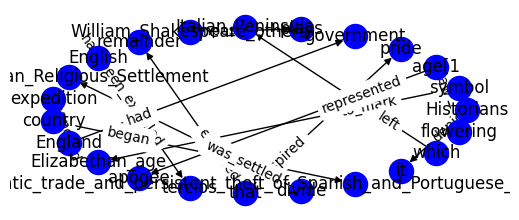

In [ ]:
nodes = []
relations = []
# iterate over the triples
for triple in triples:
    # extract the Subject and Object from triple
    node_subject = "_".join(map(str, triple.subject))
    node_object  = "_".join(map(str, triple.object))
    nodes.append(node_subject)
    nodes.append(node_object)
    # extract the relation between S and O
    # add the attribute 'action' to the relation
    relation = "_".join(map(str, triple.verb))
    relations.append((node_subject,node_object,{'action':relation}))
# remove duplicate nodes
nodes = list(set(nodes))
print(nodes)

print(relations)
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(relations)
# extract the attribute 'action' from edges
edge_attribute = nx.get_edge_attributes(G, 'action')
edges, weights = zip(*edge_attribute.items())
# resize figure
plt.rcParams["figure.figsize"] = [5, 2]
plt.rcParams["figure.autolayout"] = True
# set figure layout
pos = nx.circular_layout(G)
# draw graph
nx.draw(G, pos, node_color='b', width=1, with_labels=True)
# draw edge attributes
nx.draw_networkx_edge_labels(G, pos,edge_attribute, label_pos=0.75 )
plt.show()


##Topic Modeling

In [ ]:
!pip install gensim

In [ ]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import textacy
from gensim import corpora, models
import gensim
# Preprocess the text
doc = nlp(text)
# Tokenization and removing stop words and punctuations
words = [token.text for token in doc if token.is_alpha and not token.is_stop]

# Creating the term dictionary
dictionary = corpora.Dictionary([words])

# Creating the Corpus
doc_term_matrix = [dictionary.doc2bow(words)]

# Creating the LDA model
lda = models.LdaMulticore(doc_term_matrix, num_topics=3, id2word=dictionary, passes=2)

# Print the topics
for i, topic in lda.print_topics(num_words=4):
    print(f"Topic {i}: {topic}")

Topic 0: 0.010*"English" + 0.010*"England" + 0.009*"Elizabeth" + 0.008*"Spain"
Topic 1: 0.023*"England" + 0.018*"Elizabeth" + 0.018*"English" + 0.015*"Spanish"
Topic 2: 0.015*"England" + 0.011*"Elizabeth" + 0.011*"Spain" + 0.011*"Elizabethan"


## Micrographs for major topics

Total SVO triples: 14
Triples for Topic 0: 6


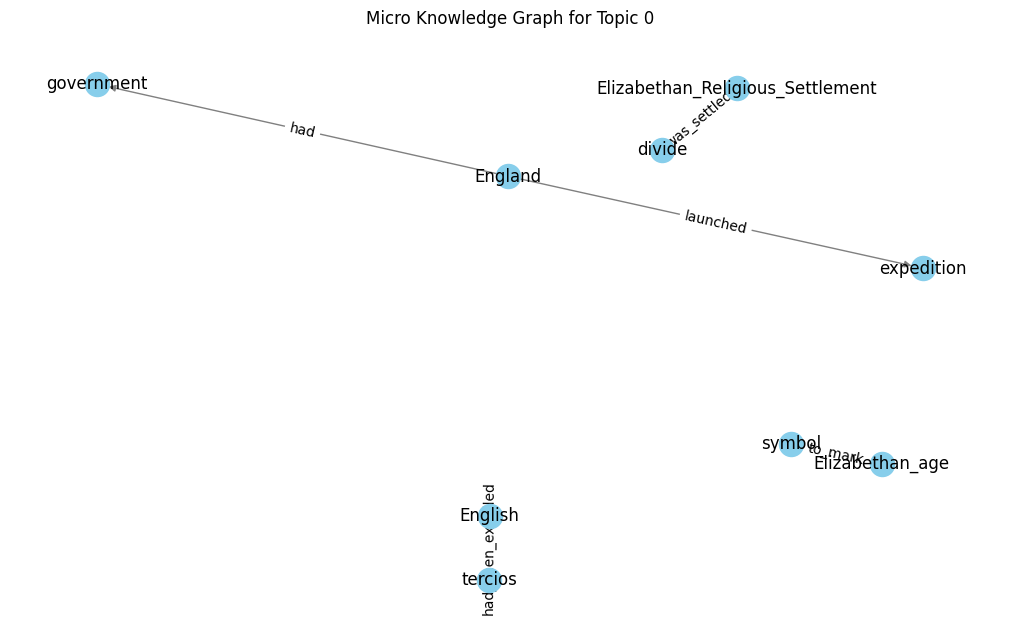

Triples for Topic 1: 7


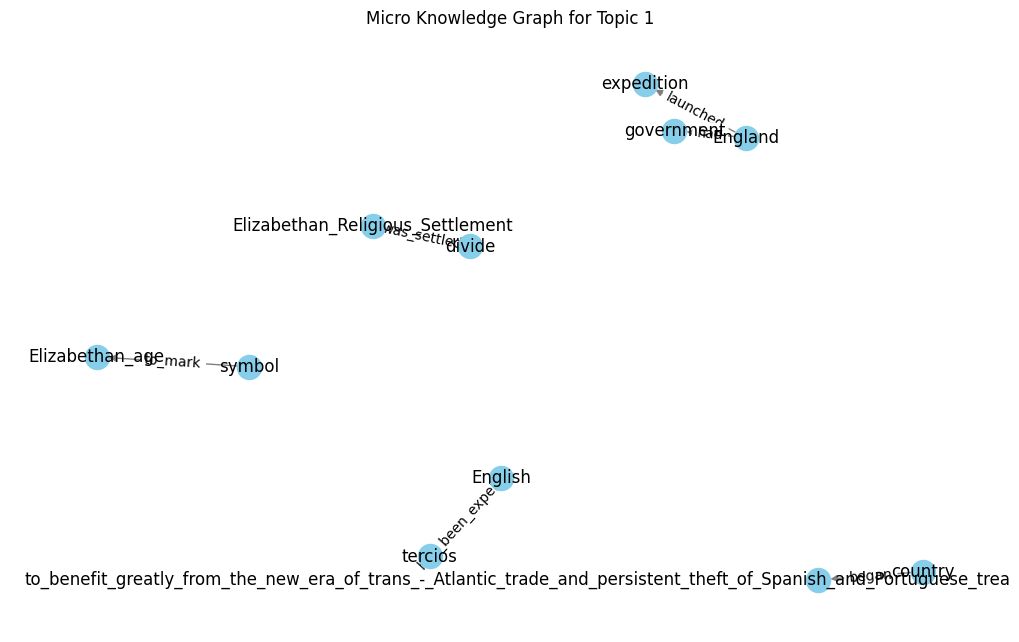

Triples for Topic 2: 6


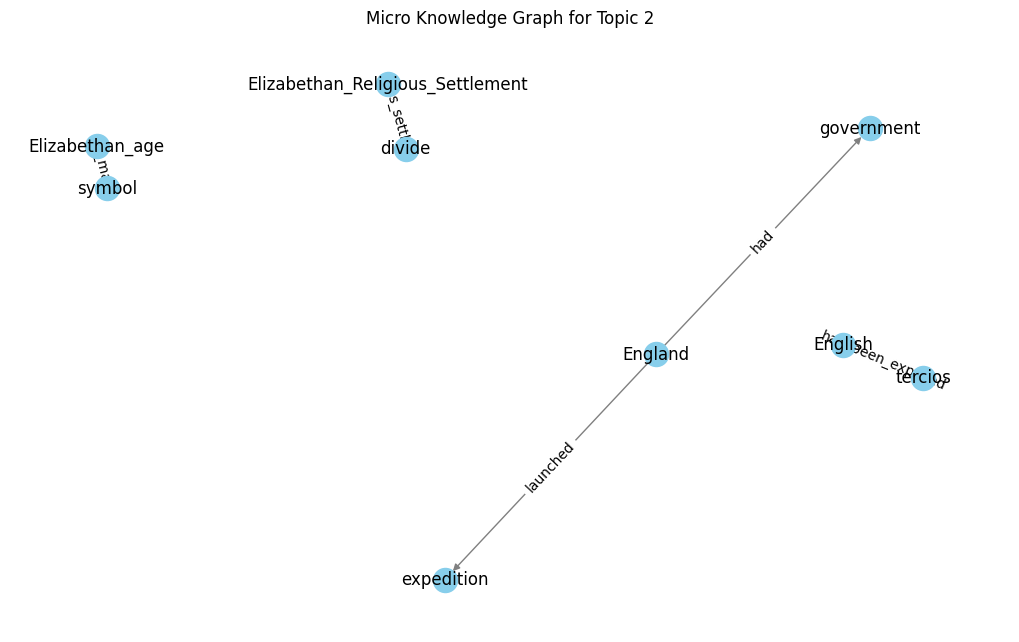

In [ ]:


# Extract SVO triples
triples = list(textacy.extract.subject_verb_object_triples(doc))
print("Total SVO triples:", len(triples))

# Define key terms for each topic based on your LDA output
topic_keywords = {
    "Topic 0": ["england", "elizabethan", "english", "elizabeth"],
    "Topic 1": ["england", "elizabeth", "spanish", "english"],
    "Topic 2": ["england", "english", "elizabeth", "spain"]
}

# Function to filter triples by keywords
def filter_triples_by_keywords(triples, keywords):
    filtered_triples = []
    for triple in triples:
        triple_text = " ".join(map(str, [triple.subject, triple.verb, triple.object])).lower()
        if any(keyword in triple_text for keyword in keywords):
            filtered_triples.append(triple)
    return filtered_triples

# Create micro knowledge graphs for each topic
for topic, keywords in topic_keywords.items():
    topic_triples = filter_triples_by_keywords(triples, keywords)
    print(f"Triples for {topic}: {len(topic_triples)}")

    G = nx.DiGraph()

    for triple in topic_triples:
        subject = "_".join(map(str, triple.subject))
        obj = "_".join(map(str, triple.object))
        action = "_".join(map(str, triple.verb))
        G.add_edge(subject, obj, label=action)

    if len(G.nodes) > 0:
        plt.figure(figsize=(10, 6))
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.title(f"Micro Knowledge Graph for {topic}")
        plt.show()
    else:
        print(f"No data to display for {topic}")


## Represent the Poem as a knowledge graph

In [ ]:
# Load spacy model
nlp = spacy.load('en_core_web_sm')
# Plain text
poem_text = "my mistress eyes are nothing like the sun coral is far more red than her lips red if snow be white why then her breasts are dun if hairs be wires black wires grow on her head have seen roses damask red and white but no such roses see in her cheeks and in some perfumes is there more delight than in the breath that from my mistress reeks love to hear her speak yet well know that music hath far more pleasing sound grant never saw goddess go my mistress when she walks treads on the ground and yet by heaven think my love as rare as any she belied with false compared"
# Process plain text with spacy
doc = nlp(poem_text)
triples = list(textacy.extract.subject_verb_object_triples(doc))
print(triples)

[SVOTriple(subject=[that], verb=[love], object=[to, hear, her, speak]), SVOTriple(subject=[goddess], verb=[go], object=[mistress]), SVOTriple(subject=[she], verb=[walks], object=[treads])]


['goddess', 'mistress', 'she', 'to_hear_her_speak', 'that', 'treads']
[('that', 'to_hear_her_speak', {'action': 'love'}), ('goddess', 'mistress', {'action': 'go'}), ('she', 'treads', {'action': 'walks'})]


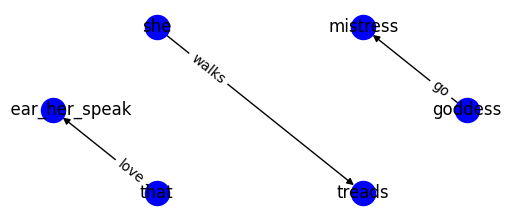

In [ ]:
nodes = []
relations = []
# iterate over the triples
for triple in triples:
    # extract the Subject and Object from triple
    node_subject = "_".join(map(str, triple.subject))
    node_object  = "_".join(map(str, triple.object))
    nodes.append(node_subject)
    nodes.append(node_object)
    # extract the relation between S and O
    # add the attribute 'action' to the relation
    relation = "_".join(map(str, triple.verb))
    relations.append((node_subject,node_object,{'action':relation}))
# remove duplicate nodes
nodes = list(set(nodes))
print(nodes)

print(relations)
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(relations)
# extract the attribute 'action' from edges
edge_attribute = nx.get_edge_attributes(G, 'action')
edges, weights = zip(*edge_attribute.items())
# resize figure
plt.rcParams["figure.figsize"] = [5, 2]
plt.rcParams["figure.autolayout"] = True
# set figure layout
pos = nx.circular_layout(G)
# draw graph
nx.draw(G, pos, node_color='b', width=1, with_labels=True)
# draw edge attributes
nx.draw_networkx_edge_labels(G, pos,edge_attribute, label_pos=0.75 )
plt.show()

# Connect Knowledge graphs of news article and poem using Transitive Closure and to compare the article and the poem for similarity

In [ ]:
nlp = spacy.load('en_core_web_sm')

def build_graph(text):
    doc = nlp(text)
    triples = list(textacy.extract.subject_verb_object_triples(doc))

    nodes = set()
    edges = []
    for triple in triples:
        subject = "_".join(map(str, triple.subject))
        obj = "_".join(map(str, triple.object))
        verb = "_".join(map(str, triple.verb))

        nodes.add(subject)
        nodes.add(obj)
        edges.append((subject, obj, {'action': verb}))

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    return G

In [ ]:
# Function to compute transitive closure

def compute_transitive_closure(G):
    return nx.transitive_closure(G)

In [ ]:
# compare the graphs

def compare_graphs(G1, G2):
    common_nodes = len(set(G1.nodes()).intersection(set(G2.nodes())))
    total_nodes = len(set(G1.nodes()).union(set(G2.nodes())))

    common_edges = len(set(G1.edges()).intersection(set(G2.edges())))
    total_edges = len(set(G1.nodes()).union(set(G2.nodes())))

    node_similarity = common_nodes / total_nodes
    edge_similarity = common_edges / total_edges

    return node_similarity, edge_similarity

In [ ]:
text_article = text
text_poem = poem_text

print(text_article)
print(text_poem)

# Build graphs
G_article = build_graph(text_article)
G_poem = build_graph(text_poem)

The Elizabethan era is the epoch in the Tudor period of the history of England during the reign of Queen Elizabeth I (1558–1603). Historians often depict it as the golden age in English history. The symbol of Britannia (a female personification of Great Britain) was first used in 1572, and often thereafter, to mark the Elizabethan age as a renaissance that inspired national pride through classical ideals, international expansion, and naval triumph over Spain.This golden age[1] represented the apogee of the English Renaissance and saw the flowering of poetry, music and literature. The era is most famous for its theatre, as William Shakespeare and many others composed plays that broke free of England's past style of theatre. It was an age of exploration and expansion abroad, while back at home, the Protestant Reformation became more acceptable to the people, most certainly after the Spanish Armada was repelled. It was also the end of the period when England was a separate realm before it

In [ ]:
# Compute Transitive Closure

G_article_closure = compute_transitive_closure(G_article)
G_poem_closure = compute_transitive_closure(G_poem)

print(f"Transitive Closure of Article: {G_article_closure}")
print(f"Transitive Closure of Article: {G_poem_closure}")

Transitive Closure of Article: DiGraph with 23 nodes and 13 edges
Transitive Closure of Article: DiGraph with 6 nodes and 3 edges


In [ ]:
# Comparing knowledge graphs for similarity

node_similarity, edge_similarity = compare_graphs(G_article_closure, G_poem_closure)
print(f"Graphs Node Similarity: {node_similarity}")
print(f"Graphs Edge Similarity: {edge_similarity}")

Graphs Node Similarity: 0.03571428571428571
Graphs Edge Similarity: 0.0




# Conclusion
-Graph Node Similarity (0.03571428571428571):
-This value suggests a low level of similarity between the nodes (elements) in the graph representations of the article and poem. In the context of comparing an article and a poem, nodes could represent words, phrases, or sentences within the texts.
-A low node similarity indicates that there are relatively few common elements between the two texts. This could mean that the content and structure of the article and poem are distinct from each other.

-Graph Edge Similarity (0.0):

A graph edge represents a relationship or connection between nodes. In the context of text analysis, edges could represent dependencies, co-occurrences, or any form of semantic relationships between words or phrases.
A zero edge similarity suggests that there are no shared relationships or connections between the elements (nodes) in the graph representations of the article and poem.

